# Task 2.1 Static logit + model code design

Here we build a codebase that would be typical in working with any structural model using static RUM model as an testbed example:

1. Model definition object and "model parts"
2. Solver
3. Simulator
4. Graphical module
5. Estimator (not today)
6. Counter factual simulator (not today)

A good way to modularize the code is to separate the main components of the model in classes and functions from the *run* scripts that call these functions to do stuff.

**Model specification**

Consider two specifications of static RUM model with EV1 random terms:
1. Linear utility of the form $u(d,x)=Y^d \beta^x$ where $Y^d$ is the vector of attributes of alternative $d$ and $\beta^x$ is the vector of structural parameters associated with the state (of the decision maker) $x$.  Let $x \in \{1,2\}$ and $\beta^1 = \beta$, $\beta^2 = \beta/2$ with $\beta$ the vector of structural parameters
2. Non-linear utility of the form $u(d,x)=\ln(Y^d) \beta^x$ with the same specification for $\beta^x$

**Coding tasks**:
1. Develop the model class to hold the parameters of the model, test its functionality
2. Write the solver of the model, make sure the logit is demaxed
3. Write graphical routine to show model solution
  - bar plot showing choice probabilities for each value of the state
4. Write the simulator of the model (to simulate a given N number of decision makers)
5. Write graphical routine to show simulated data from the model
  - bar plot showing histogram of simulated choices for each value of the state
6. Create dashboard to visualize model attributes, solution and simulations
  - alternative attributes
  - structural coefficients
  - choice probabilities (solution) by state
  - histograms of simulated choices by state

**Model understanding tasks**:
1. Explore the role of each $\beta$ parameter of the linear model using dashboard
2. Explore the role of $\sigma$ parameter of the model using dashboard
3. Explore the difference between predicted and simulated behavior
4. Is it possible to find parameter values such that all simulated choices concentrate on one alternative?
5. Is it possible to mimic the behavior of decision maker is state $x=1$ using state $x=2$ and a different set of parameters?
6. Do answers to the above questions change in the non-linear model?

Tip: use of previous examples and AI assistance speeds up work 😉

In [1]:
# Class to store model parameters
import numpy as np

class model:
  '''Class to hold RUM model specifications'''

  def __init__(
      self,
      label='noname',
      nalt=1,           # number of alternatives
      nattr=1,          # number of attributes for each alternative
      attr=[],          # values of alternative attributes (Y)
      param=[],         # structural parameters of the model (beta)
      st=[],            # state of the decision maker (X)
      sigma=1.0):
    '''Create model with default parameters'''
                        # store parameters in the mode object

  def __str__(self):
    '''String representation of the model'''
    # Human readable representation of the model
    return 'Human readable representation of the model'

  def __setattr__(self, attr: str, value):
    '''Check consistency of the class attributes'''
    pass

  # Model parts
  def utility():
    '''Specification of the deterministic component of utility'''
    pass

  def save_chpr(selt):
    '''Stores computed choice probabilities (solution) in the model object'''

def model_solve(m: model):
  '''Solver for the the model, returns optimal choice probabilities'''
  # Store the solution as part of model object
  pass

def model_simulate(m: model):
  '''Simulator for the the model, returns simulated data'''
  pass


In [2]:
# Class to store model parameters
import numpy as np
import pandas as pd

class model:
  '''Class to hold RUM model specifications'''

  def __init__(
      self,
      label='noname',
      nalt=5,                # number of alternatives
      nattr=3,               # number of attributes for each alternative
      attr=np.array([]),     # values of alternative attributes (Y)
      param=np.array([]),    # structural parameters of the model (beta)
      st=np.array([1, 2]),   # state of the decision maker (X)
      util_type='linear',      # linear or log
      sigma=1.0):
    '''Create model with default parameters'''

    # store parameters in the model object
    self.label = label
    self.nalt = nalt
    self.nattr = nattr
    self.attr = attr
    self.param = param
    self.st = st
    self.util_type = util_type
    self.sigma = sigma

  def __str__(self):
    '''String representation of the model'''
    # Human readable representation of the model
    return f'Model "{self.label}": {self.nalt} alternatives and {self.nattr} attributes, structural parameters are {np.array2string(self.param, separator=', ')}'

  def __setattr__(self, attr: str, value):
    '''Check consistency of the class attributes'''
    if attr == 'attr':
      # check that the values of the alternative attributes have correct dimensions
      assert value.shape == (self.nalt, self.nattr), 'Wrong shape of the alternatives data'
    if attr == 'param':
      assert value.size == self.nattr, 'Wrong shape of the parameter coefficients'
    super().__setattr__(attr, value)

  # Model parts
  def beta_coef(self):
    '''Returns two columns of beta parameters'''
    beta_st = np.empty((self.nattr, self.st.size)) # state-specific coefficients
    beta_st[:, 0] = self.param
    beta_st[:, 1] = self.param / 2
    return beta_st

  def utility(self):
    '''Specification of the deterministic component of utility'''
    # returns matrix with alternatives in rows, states in columns
    if self.util_type == 'linear':
      return self.attr @ self.beta_coef()
    elif self.util_type == 'log':
      return np.log(self.attr) @ self.beta_coef()
    else:
      raise ValueError('Unknown utility specification')

  def save_chpr(self, chpr: np.ndarray):
    '''Stores computed choice probabilities (solution) in the model object'''
    self.solution = chpr


def model_solve(m: model):
  '''Solver for the the model, returns optimal choice probabilities'''
  chpr = m.utility()/m.sigma # utility for alternatives in rows, over states (cols)
  # compute logit chpr with DEMAX
  mx = np.max(chpr, axis=0) # max over rows/alternatives
  chpr = np.exp(chpr - mx) # exp of demaxed
  chpr /= np.sum(chpr, axis=0) # divide by sums of exp over rows/alternatives
  m.save_chpr(chpr) # Store the solution as part of model object
  return chpr

def model_simulate(m: model, chpr: np.ndarray = None, nobs: int = 10):
  '''Simulator for the the model, returns simulated data
  Input: model and number of observations to simulate
  Return: pandas dataframe
  '''
  assert chpr is not None or hasattr(m, 'solution'), 'Model has to have been solved before simulation or choice probabilities have to be provided to the simulator'
  # use solution unless CCPs are supplied directly
  if chpr is None:
    chpr = m.solution
  # 1. start building Pandas dataset
  var_names = ['id','st','choice'] + [f"attr{i}" for i in range(1,m.nattr+1)]
  data = pd.DataFrame(np.nan, index=range(nobs), columns=var_names)
  data['id']=1+np.arange(nobs)
  # 2. draw states
  nst = m.st.size
  data['st']=np.random.randint(m.st.size,size=nobs)
  # 3. draw discrete random variables by state
  cumulative = np.cumsum(chpr,axis=0) # cumulative probabilities
  u = np.random.rand(nobs) # uniform draws on [0,1]
  for st in range(nst):
    mask = data['st']==st # mask for all obs with given st
    # simulate choices = find interval in relevant comulative distribution that contains simulated uniform[0,1]
    data.loc[mask,'choice'] = np.searchsorted(cumulative[:,st], u[mask], side="right")
    # add chosen alternative attributes to the dataset
    data.loc[mask, var_names[3:]] = m.attr[data.loc[mask,'choice'].astype(int), :]
  # add correct dtypes to the variables
  dtypes = [np.int32, np.int32, np.int32] + [np.float32 for _ in range(m.nattr)]
  data = data.astype(dict(zip(var_names, dtypes)))
  return data

In [3]:
alternatives = 5
attributes = 3
attr_data = np.random.rand(alternatives, attributes)
beta_vec = np.array([0.5, 0.3, 0.2])

m1 = model(nalt=alternatives, nattr=attributes, attr=attr_data, param=beta_vec)
print(m1)

model_solve(m1)
simdata = model_simulate(m1,nobs=2500)
simdata.head()

Model "noname": 5 alternatives and 3 attributes, structural parameters are [0.5, 0.3, 0.2]


,id,st,choice,attr1,attr2,attr3
0,1,1,2,0.175758,0.662468,0.943756
1,2,0,1,0.672393,0.071500,0.669118
2,3,1,3,0.231017,0.044907,0.357866
3,4,1,3,0.231017,0.044907,0.357866
4,5,0,2,0.175758,0.662468,0.943756


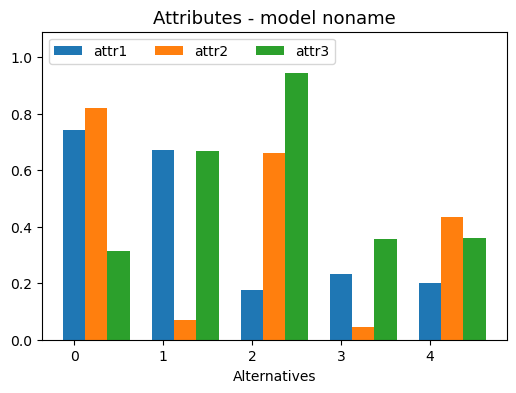

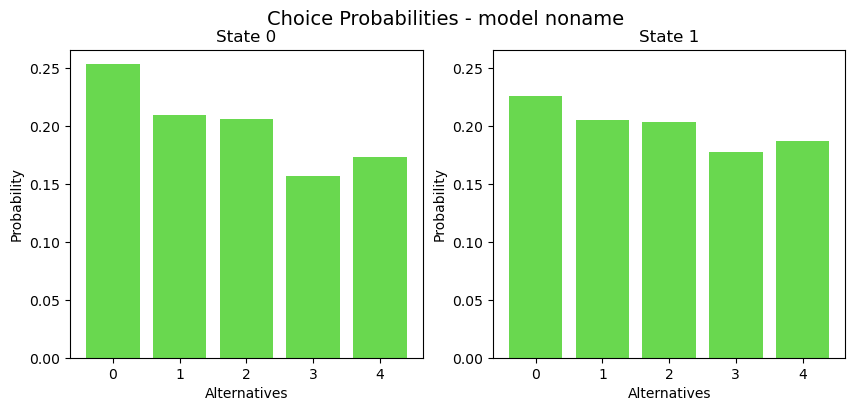

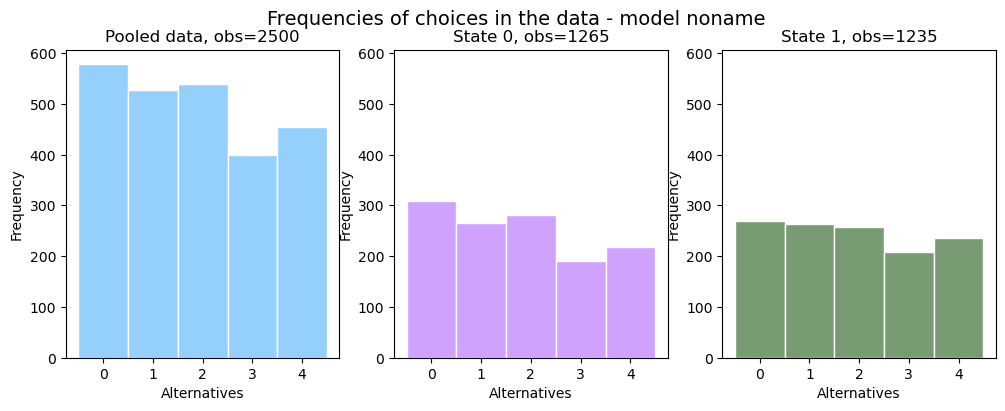

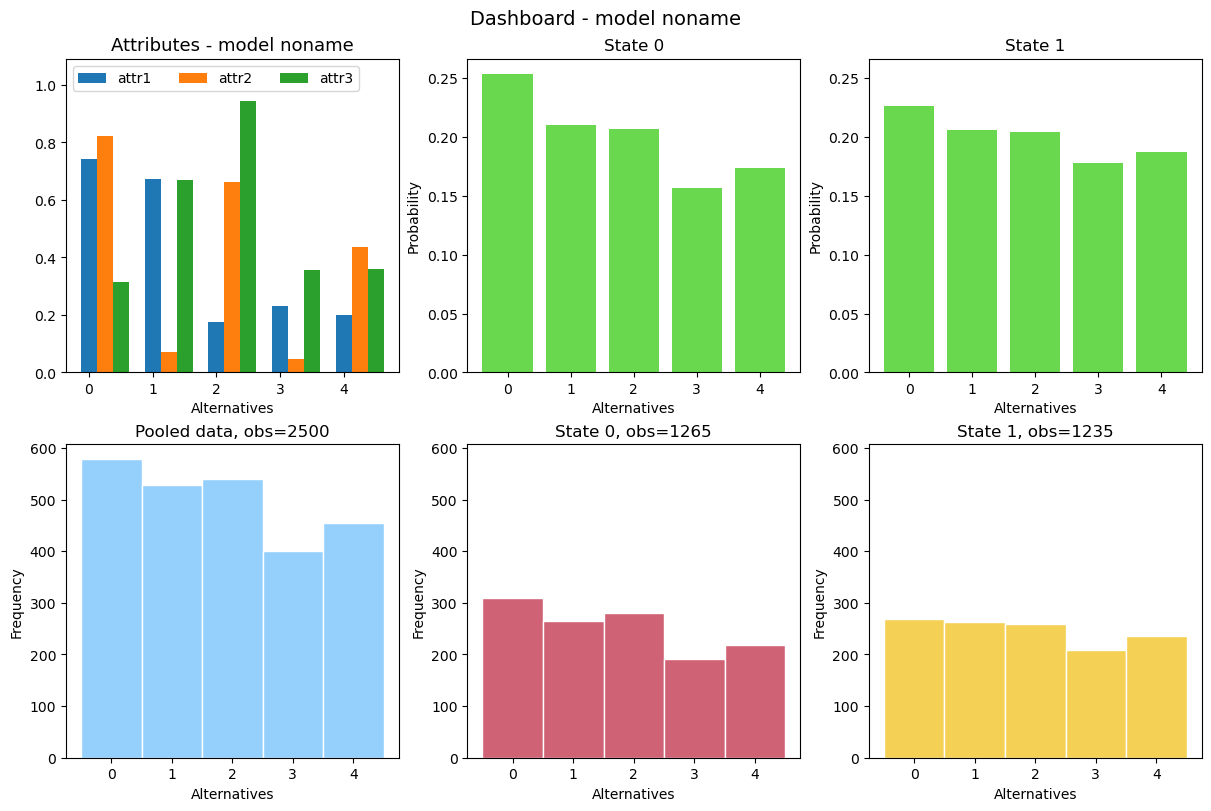

In [4]:
import matplotlib
import matplotlib.pyplot as plt

def plot_choice_probabilities(m: model, ax=None):
  '''Plot choice probabilities for the model
  Inputs: model
          ax - axes in a list, optional
  '''
  assert hasattr(m, 'solution'), 'Model has to be solved before plotting choice probabilities'
  if ax is None:
    fig = plt.figure(figsize=(10, 4))
    ax = []
    for i in range(m.st.size):
      ax.append(fig.add_subplot(1, m.st.size, i + 1))
    fig.suptitle(f"Choice Probabilities - model {m.label}", fontsize=14)
  # make plot
  ymax = 0
  for i in range(min(len(ax), m.st.size)):
    # plot new state on each of the plots (assuming the quantity is right)
    ax[i].bar(range(m.nalt), m.solution[:, i], color="xkcd:fresh green")
    ax[i].set_title(f"State {i}", fontsize=12)
    ax[i].set_xlabel("Alternatives", fontsize=10)
    ax[i].set_ylabel("Probability", fontsize=10)
    ymax = max(ymax, ax[i].get_ylim()[1])
  # make sure that ymax is the same across all plots
  for i in range(min(len(ax), m.st.size)):
    ax[i].set_ylim(0, ymax)


def plot_attributes(m: model, ax=None):
  '''Plot attributes of the alternatives
  Inputs: model
          ax - axes, optional
  '''
  if ax is None:
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
  # build the multiple bar plot
  x = np.arange(m.nalt)      # the label locations
  width = 0.25               # the width of the bars
  multiplier = 0
  for i in range(m.attr.shape[1]):
    offset = width * multiplier
    b = ax.bar(x + offset, m.attr[:, i], width, label=f'attr{i+1}')
    multiplier += 1
  ax.set_ylim(0, ax.get_ylim()[1]*1.1)
  ax.set_title(f"Attributes - model {m.label}", fontsize=13)
  ax.set_xlabel("Alternatives", fontsize=10)
  ax.legend(loc='upper left', ncols=m.nattr)


def plot_data(m: model, data: pd.DataFrame, ax=None):
  '''Plot simulated data from the model'''
  clrs = list(matplotlib.colors.XKCD_COLORS.keys())
  if ax is None:
    fig = plt.figure(figsize=(12, 4))
    ax = []
    for i in range(m.st.size + 1):
      ax.append(fig.add_subplot(1, m.st.size + 1, i + 1))
    fig.suptitle(f"Frequencies of choices in the data - model {m.label}", fontsize=14)
  # make plot
  ymax = 0
  bins = np.arange(-.5, m.nalt + .5, 1)
  nax = min(len(ax), m.st.size + 1)
  for i in range(nax):
    if i == 0:
      # start by plotting aggregated histogram
      nobs = data.shape[0]
      ax[i].hist(data['choice'], bins=bins, edgecolor="white", color="xkcd:light blue", density=False)
      ax[i].set_title(f"Pooled data, obs={nobs}", fontsize=12)
    else:
      # plot new state on each of the plots (assuming the quantity is right)
      clr = clrs[np.random.randint(len(clrs))] # random color
      mask = data['st'] == i - 1               # except initial one for aggregated
      nobs = mask.sum()
      ax[i].hist(data.loc[mask, 'choice'], bins=bins, edgecolor="white", color=clr, density=False)
      ax[i].set_title(f"State {i-1}, obs={nobs}", fontsize=12)
    ax[i].set_xlabel("Alternatives", fontsize=10)
    ax[i].set_ylabel("Frequency", fontsize=10)
    ymax = max(ymax, ax[i].get_ylim()[1])
  # make sure that ymax is the same across all plots
  for i in range(nax):
    ax[i].set_ylim(0, ymax)

def plot_dashboard(m: model,data: pd.DataFrame):
  '''Create dashboard for model visualization'''
  fig = plt.figure(layout="constrained",figsize=(12, 8))
  ax = []
  ncols=m.st.size+1
  for i in range(2): # two rows
    for j in range(ncols):
      ax.append(fig.add_subplot(2,ncols,i*ncols+j+1))
  fig.suptitle(f"Dashboard - model {m.label}", fontsize=14)
  plot_attributes(m=m, ax=ax[0])
  plot_choice_probabilities(m=m, ax=ax[1:ncols])
  plot_data(m=m, data=data, ax=ax[ncols:2*ncols])

# testing the plots
plot_attributes(m1)
plot_choice_probabilities(m1)
plot_data(m1, data=simdata)
plot_dashboard(m1, data=simdata)

In [5]:
# Let's answer the "model understanding" questions
# Fix dimensions and attributions for further analysis
nalt,nattr = 5, 3
attr = np.random.uniform(1,10,size=(nalt, nattr))

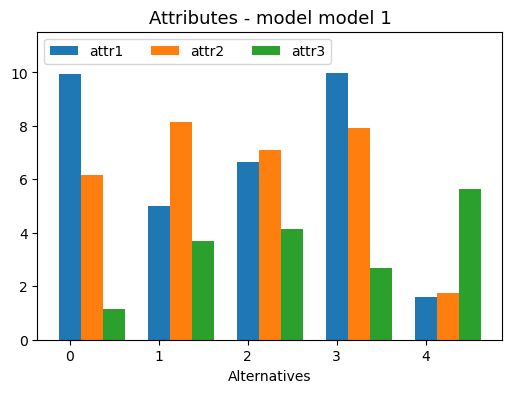

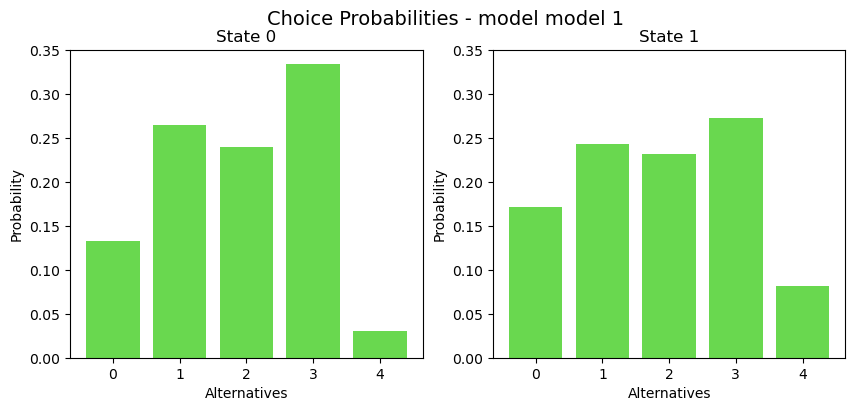

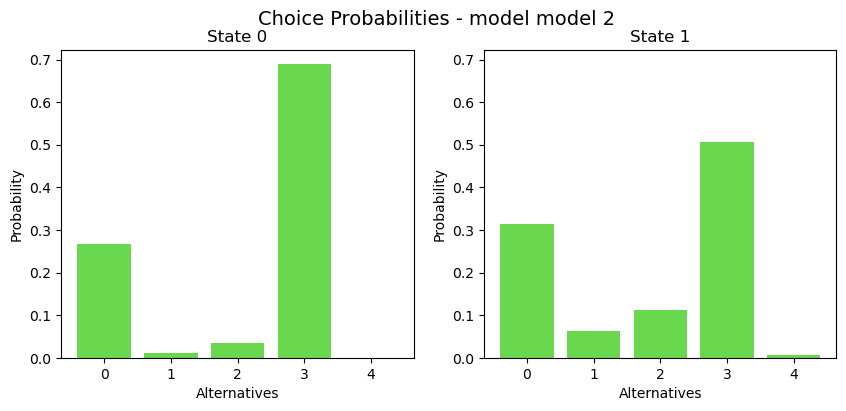

In [6]:
# first set of structural parameters
beta = np.array([0.1, 0.35, 0.2])
m1 = model(nalt=nalt, nattr=nattr, attr=attr, param=beta, label='model 1')
# second set of structural parameters
beta = np.array([0.9,0.35,0.2])
m2 = model(nalt=nalt, nattr=nattr, attr=attr, param=beta, label='model 2')
# solve models
model_solve(m1)
model_solve(m2)
plot_attributes(m1)
plot_choice_probabilities(m1)
plot_choice_probabilities(m2)
# Change in each structural parameter completely changes the profile of choice probabilities

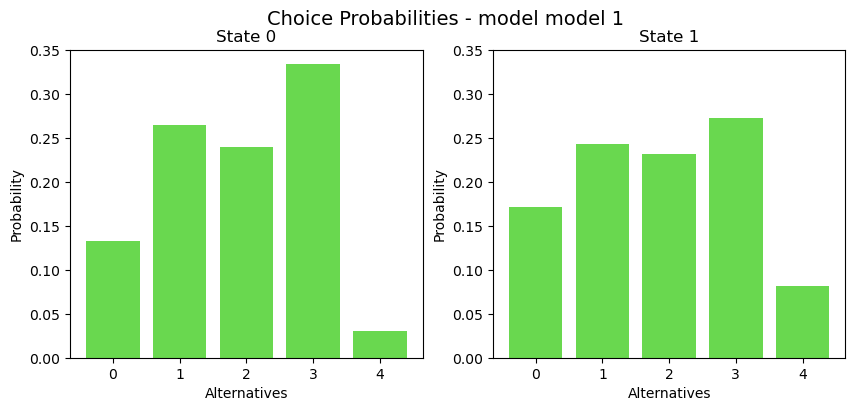

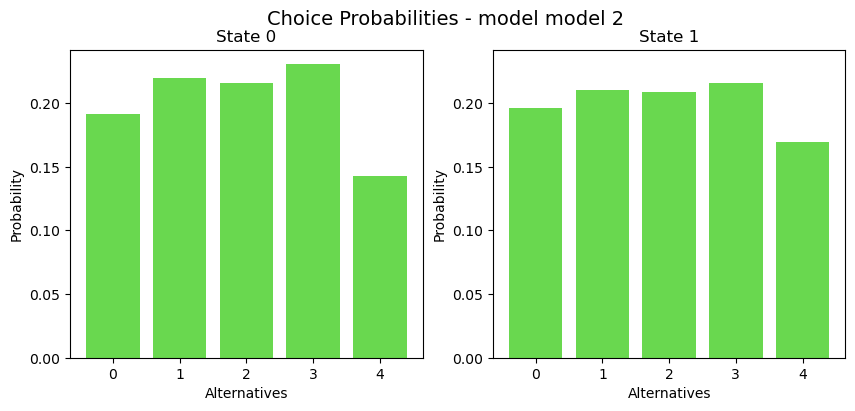

In [7]:
# The role of sigma parameter
m2.param = m1.param
m2.sigma = 5 * m1.sigma
model_solve(m1)
model_solve(m2)
plot_choice_probabilities(m1)
plot_choice_probabilities(m2)
# Higher sigma moves all choice probabilities towards uniform distribution

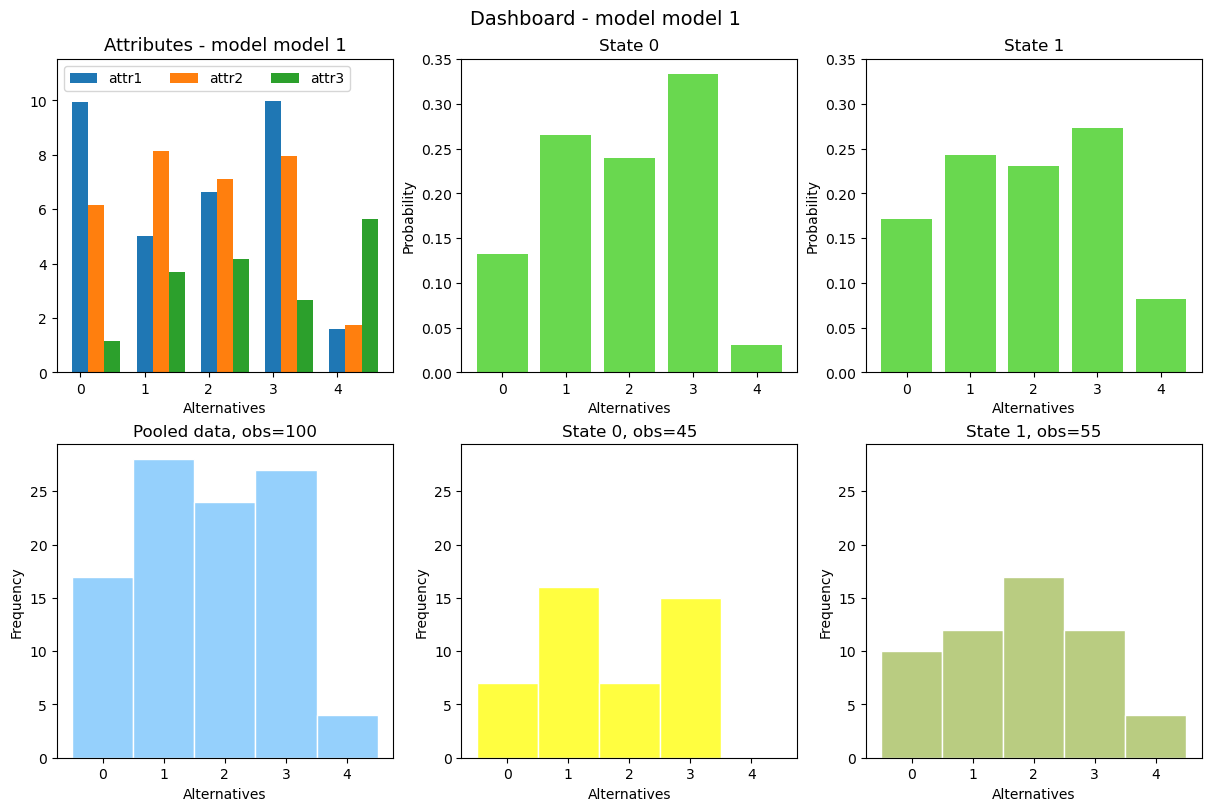

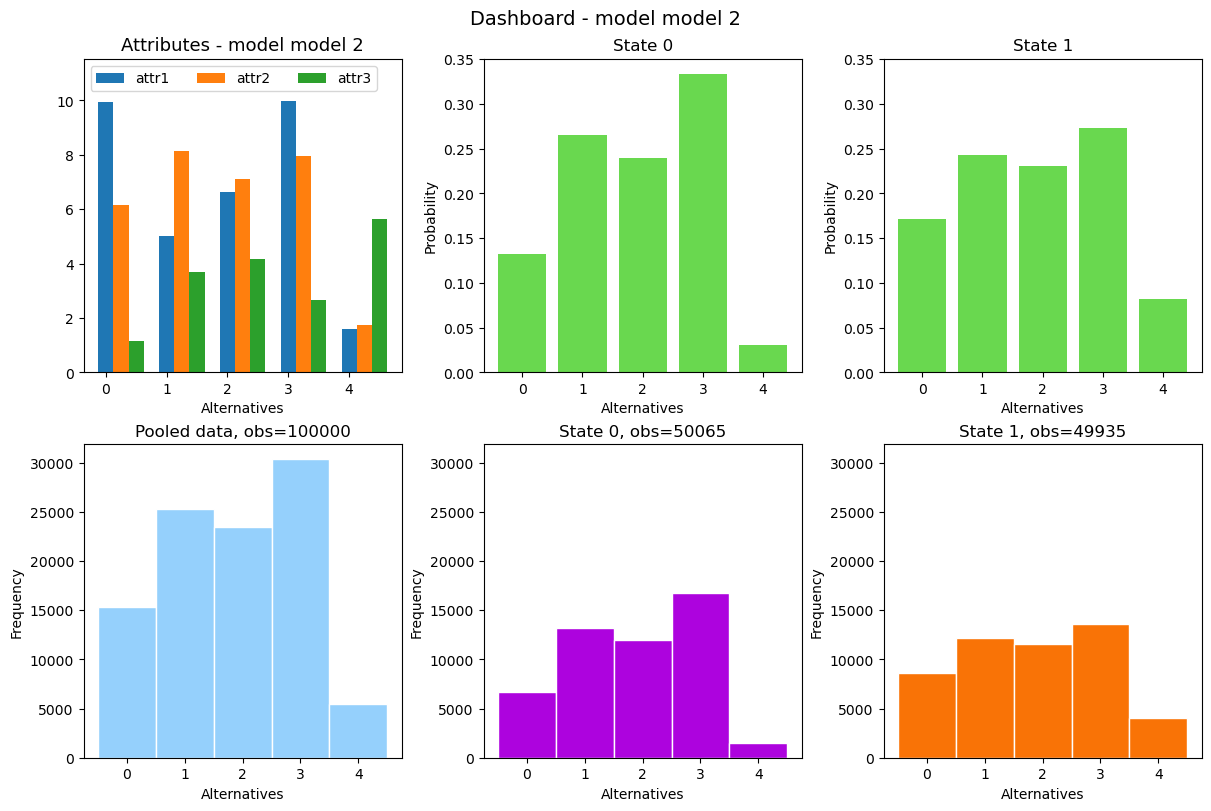

In [8]:
# Simulated data vs model solution with exact choice probabilities
m2.sigma = m1.sigma
model_solve(m1)
model_solve(m2)
simdata1=model_simulate(m1, nobs=100)
simdata2=model_simulate(m2, nobs=100_000)
plot_dashboard(m=m1, data=simdata1)
plot_dashboard(m=m2, data=simdata2)
# Law of large numbers works

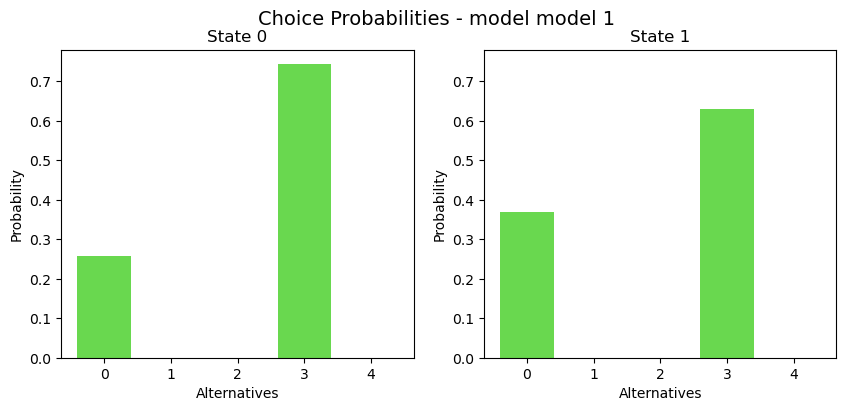

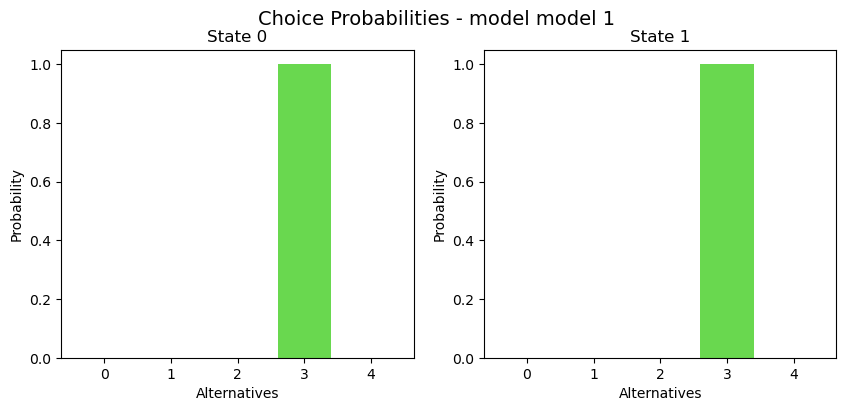

In [9]:
# concentrate all choice in one alternative
m1.param = np.array([0.1, 0.35, 0.2])
m1.param[0] = 5.1
model_solve(m1)
plot_choice_probabilities(m1)# or by sigma
m1.param = np.array([0.1, 0.35, 0.2])
m1.sigma = 0.001
model_solve(m1)
plot_choice_probabilities(m1)

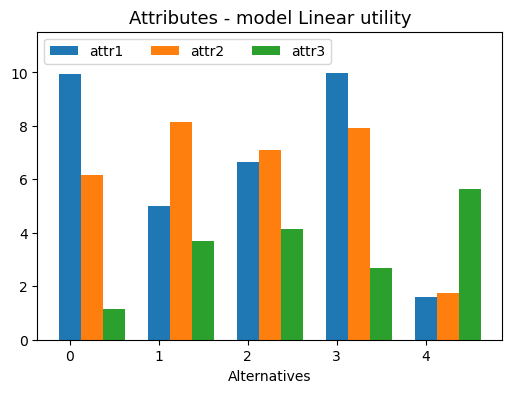

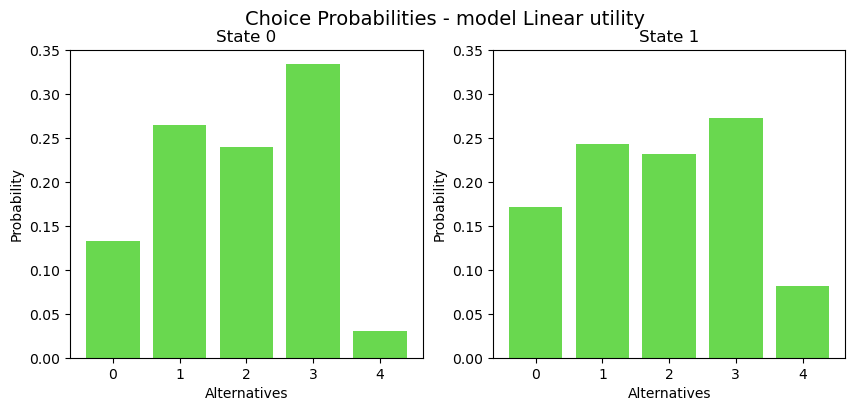

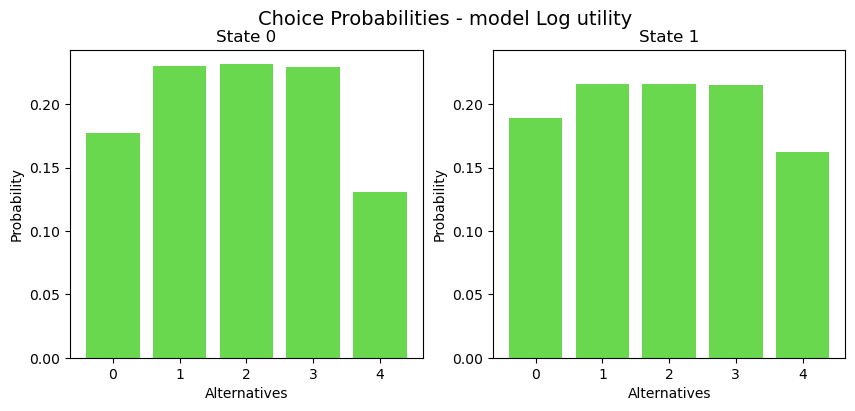

In [10]:
# difference to log utility
m1.param = np.array([0.1, 0.35, 0.2])
m1.sigma = 1.
m1.label = 'Linear utility'
m2.param = m1.param
m2.sigma = 1.
m2.util_type = 'log'
m2.label = 'Log utility'
plot_attributes(m1)
model_solve(m1)
model_solve(m2)
plot_choice_probabilities(m1)
plot_choice_probabilities(m2)